In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Встановлення бібліотеки kaggle
!pip install kaggle

# Створення папки .kaggle і переміщення kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Зміна прав доступу для kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Завантаження датасету
!kaggle datasets download -d quadeer15sh/augmented-forest-segmentation

# Розпакування завантаженого архіву
!unzip augmented-forest-segmentation.zip


Streaming output truncated to the last 5000 lines.
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_73.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_77.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_78.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_80.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_81.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_87.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_88.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_00.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_01.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_03.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_04.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_11.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_m

In [ ]:
!ls
!ls '/content/Forest Segmented/Forest Segmented'

 augmented-forest-segmentation.zip  'Forest Segmented'	 meta_data.csv	 sample_data
images	masks  meta_data.csv


In [ ]:
base_directory = '/content/Forest Segmented/Forest Segmented'


In [ ]:
images_folder = os.path.join(base_directory, 'images')
masks_folder = os.path.join(base_directory, 'masks')
data = pd.read_csv(os.path.join(base_directory, 'meta_data.csv'))

In [ ]:
data.head()

image                mask
0   10452_sat_08.jpg   10452_mask_08.jpg
1   10452_sat_18.jpg   10452_mask_18.jpg
2  111335_sat_00.jpg  111335_mask_00.jpg
3  111335_sat_01.jpg  111335_mask_01.jpg
4  111335_sat_02.jpg  111335_mask_02.jpg

In [ ]:
img_dim = 256

image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)

train_image_generator = image_datagen.flow_from_directory(
        base_directory,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 32,
        seed=42,
        subset='training')

train_mask_generator = mask_datagen.flow_from_directory(
        base_directory,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=42,
        subset='training')

val_image_generator = image_datagen.flow_from_directory(
        base_directory,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 32,
        seed=42,
        subset='validation')

val_mask_generator = mask_datagen.flow_from_directory(
        base_directory,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=42,
        subset='validation')

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 4342 images belonging to 1 classes.
Found 4342 images belonging to 1 classes.
Found 766 images belonging to 1 classes.
Found 766 images belonging to 1 classes.


In [ ]:
training_samples_size = train_image_generator.samples
val_samples_size = val_image_generator.samples

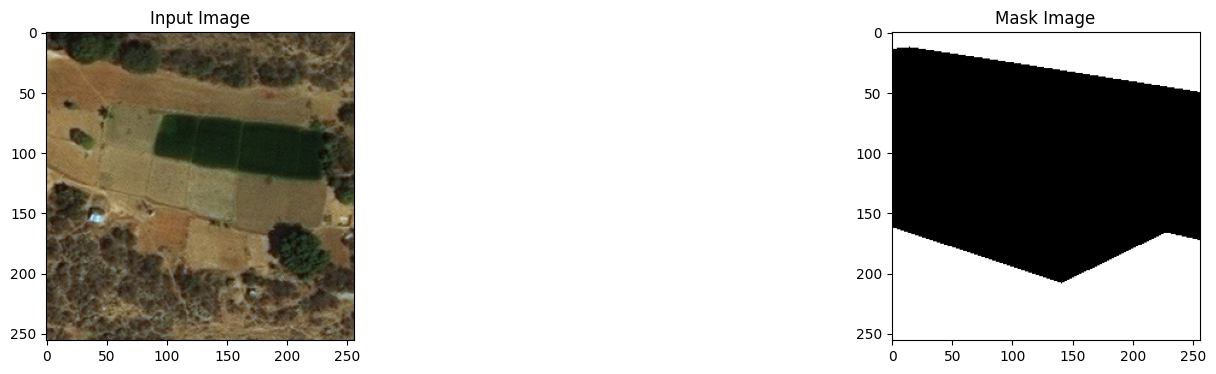

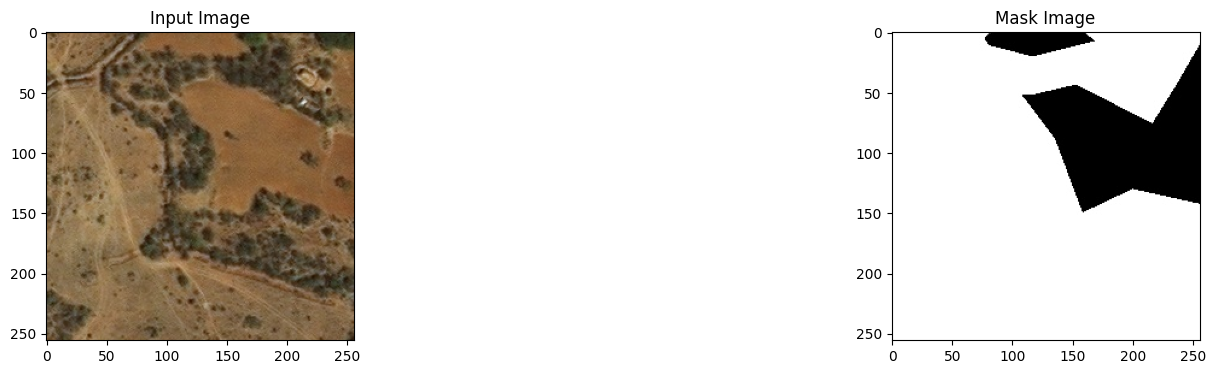

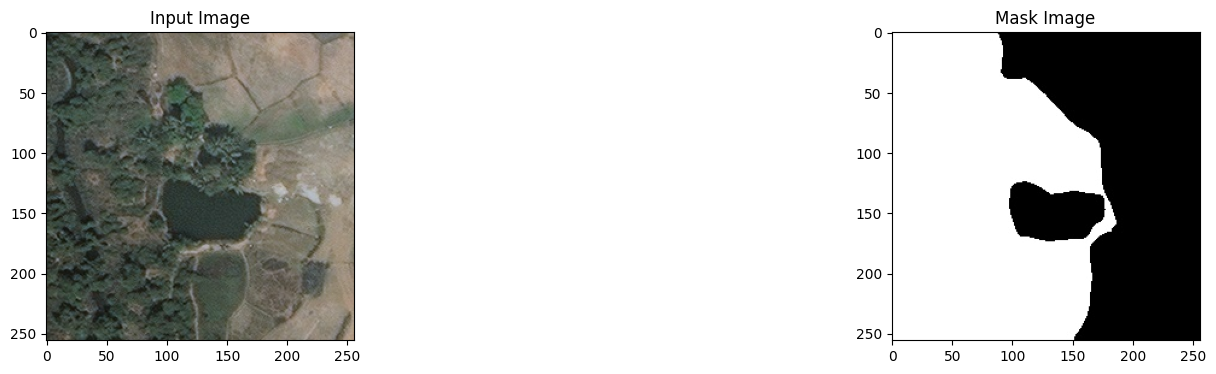

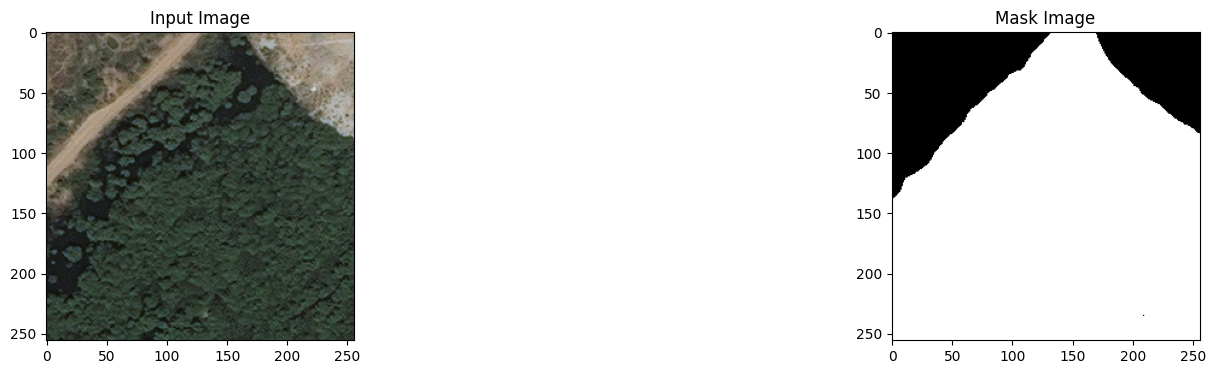

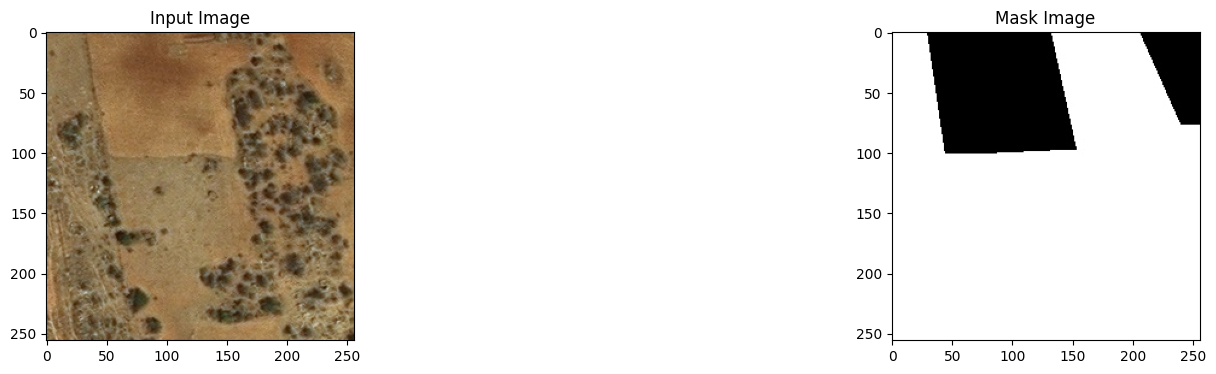

In [ ]:
n = 0
for i,m in train_generator:
    img,mask = i,m

    if n < 5:
        fig, axs = plt.subplots(1 , 2, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Input Image')
        axs[1].imshow(mask[0],cmap='gray')
        axs[1].set_title('Mask Image')
        plt.show()
        n+=1
    else:
        break

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, Conv2DTranspose

# Define AlexNet as feature extractor
def create_alexnet_feature_extractor(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    # AlexNet Feature Extractor
    x = Conv2D(96, (11, 11), strides=4, activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    return Model(inputs=inputs, outputs=x, name="AlexNet_Feature_Extractor")

In [ ]:
def build_alexnet_segmentation(input_shape=(256, 256, 3), num_classes=1):
    alexnet = create_alexnet_feature_extractor(input_shape)

    inputs = tf.keras.Input(shape=input_shape)
    x = alexnet(inputs)

    x = Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid', padding='same')(x)

    return Model(inputs=inputs, outputs=outputs, name="AlexNet_Segmentation_Model")

input_shape = (256, 256, 3)
num_classes = 1

model = build_alexnet_segmentation(input_shape, num_classes)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "AlexNet_Segmentation_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ AlexNet_Feature_Extractor            │ (None, 8, 8, 256)           │       3,747,200 │
│ (Functional)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 1)           │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,143,777 (15.81 MB)

 Trainable params: 4,143,777 (15.81 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=training_samples_size // 32,
    validation_data=val_generator,
    validation_steps=val_samples_size // 32,
    epochs=20
)


ValueError: Unrecognized data type: x=<zip object at 0x7c9a03622a40> (of type <class 'zip'>)

-------------------

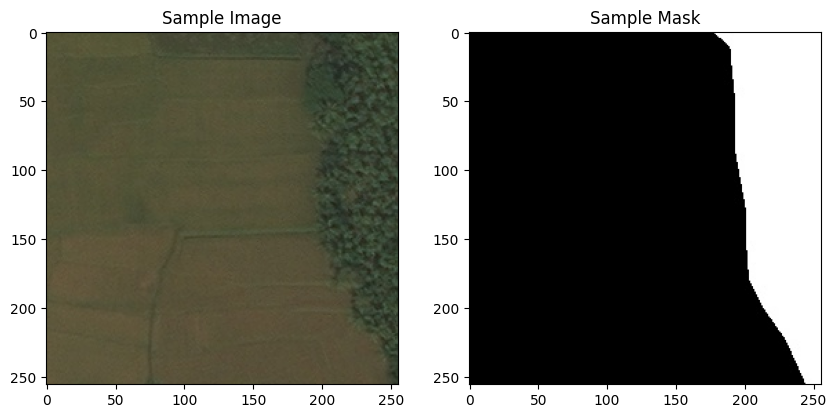

In [ ]:
image_dir = os.path.join(data_dir, 'images')
mask_dir = os.path.join(data_dir, 'masks')

image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

sample_image_path = os.path.join(image_dir, image_files[0])
sample_mask_path = os.path.join(mask_dir, mask_files[0])

image = Image.open(sample_image_path)
mask = Image.open(sample_mask_path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Sample Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Sample Mask")
plt.show()

## EDA

In [ ]:
metadata_path = os.path.join(data_dir, 'meta_data.csv')
metadata = pd.read_csv(metadata_path)
print("Metadata Information:")
metadata.info()
print(metadata.head())


Metadata Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5108 entries, 0 to 5107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5108 non-null   object
 1   mask    5108 non-null   object
dtypes: object(2)
memory usage: 79.9+ KB
               image                mask
0   10452_sat_08.jpg   10452_mask_08.jpg
1   10452_sat_18.jpg   10452_mask_18.jpg
2  111335_sat_00.jpg  111335_mask_00.jpg
3  111335_sat_01.jpg  111335_mask_01.jpg
4  111335_sat_02.jpg  111335_mask_02.jpg


In [ ]:
print(f"Number of images: {len(image_files)}")
print(f"Number of masks: {len(mask_files)}")

assert len(image_files) == len(mask_files), "Mismatch between image and mask files count!"


Number of images: 5108
Number of masks: 5108


In [ ]:
from PIL import Image

image_dimensions = [Image.open(os.path.join(image_dir, img)).size for img in image_files]
mask_dimensions = [Image.open(os.path.join(mask_dir, mask)).size for mask in mask_files]

print("Unique image dimensions:", set(image_dimensions))
print("Unique mask dimensions:", set(mask_dimensions))


Unique image dimensions: {(256, 256)}
Unique mask dimensions: {(256, 256)}


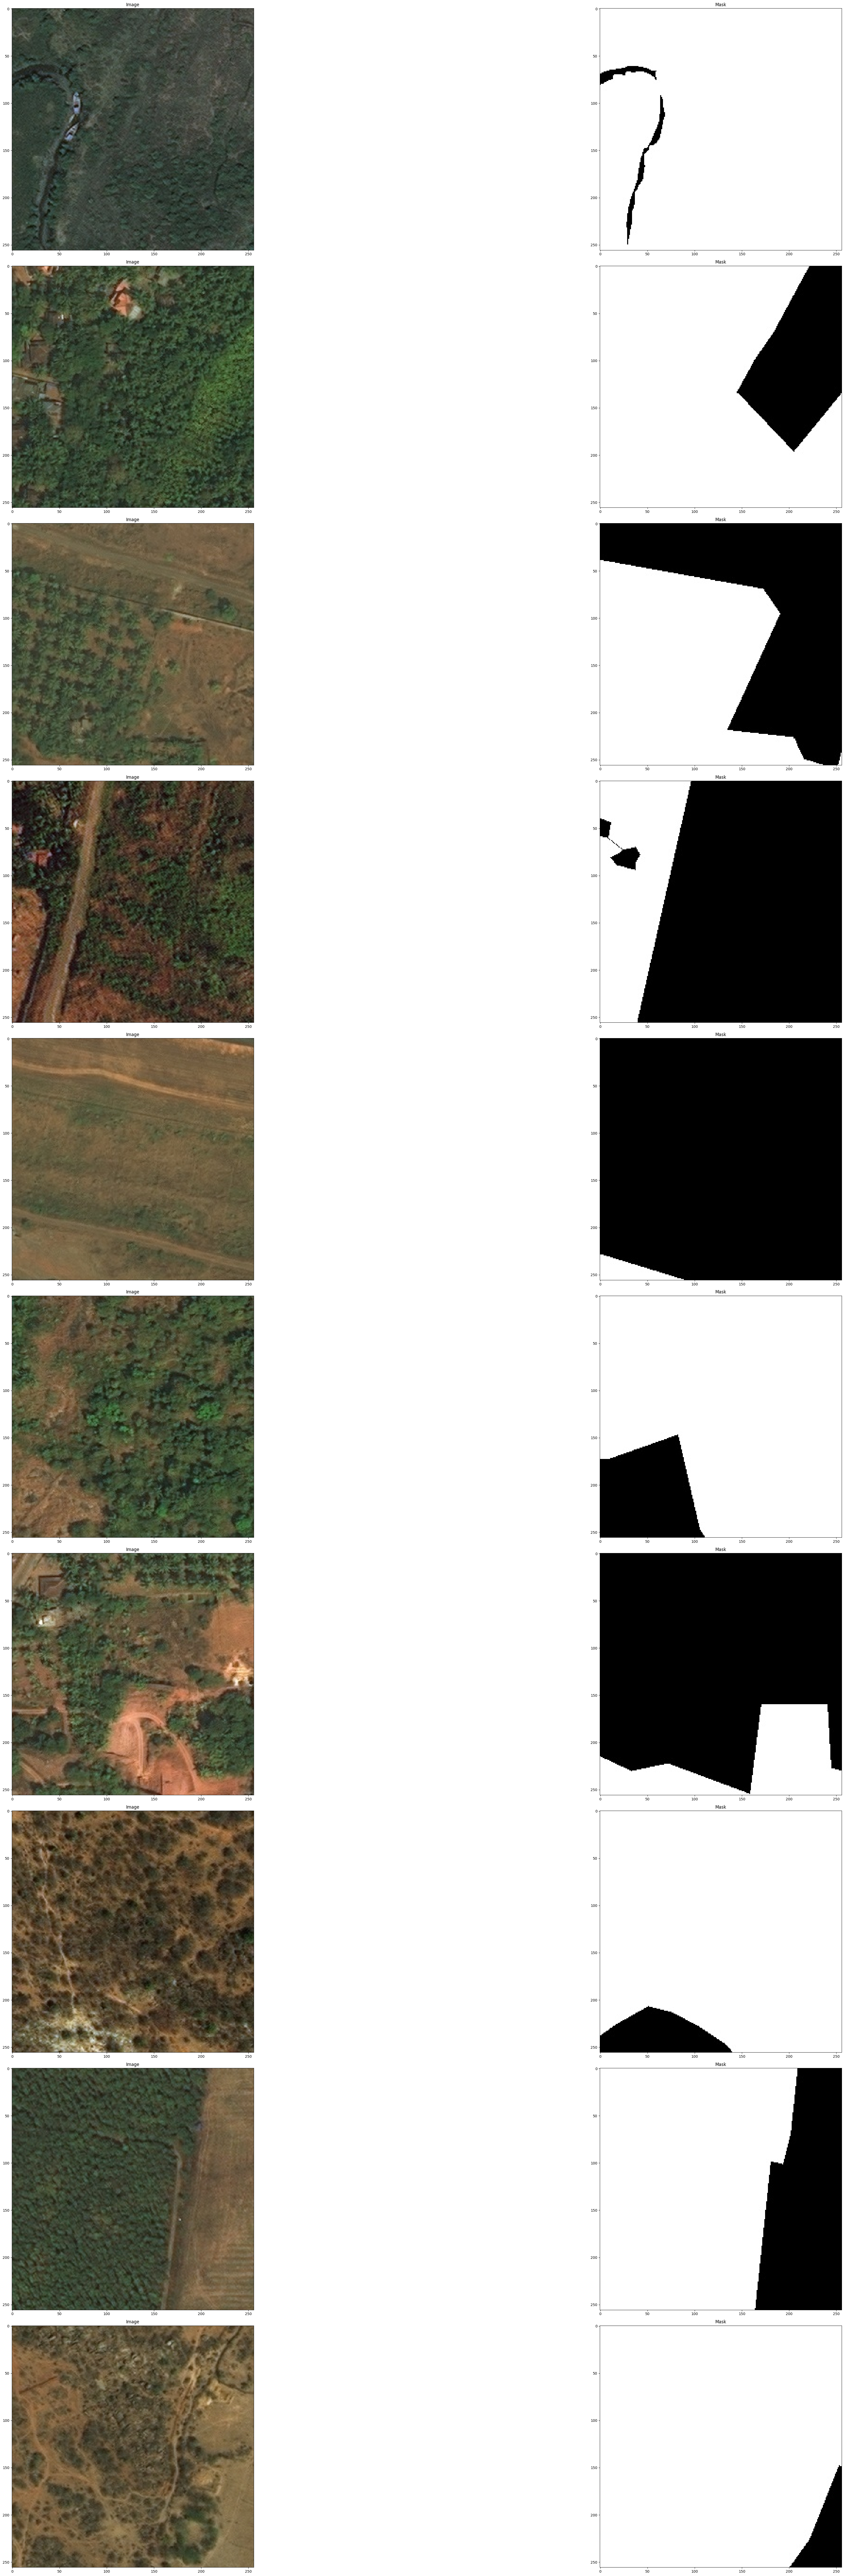

In [ ]:
import random

fig, axs = plt.subplots(10, 2, figsize=(60, 100))
for i in range(10):
    idx = random.randint(0, len(image_files) - 1)
    image = Image.open(os.path.join(image_dir, image_files[idx]))
    mask = Image.open(os.path.join(mask_dir, mask_files[idx]))

    axs[i, 0].imshow(image)
    axs[i, 0].set_title("Image")
    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].set_title("Mask")

plt.tight_layout()
plt.show()


# Preprocessing

In [ ]:
img_dim = 256
image_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)

train_image_generator = image_datagen.flow_from_directory(
        data_dir,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 32,
        seed=42,
        subset='training')

train_mask_generator = mask_datagen.flow_from_directory(
        data_dir,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=42,
        subset='training')

val_image_generator = image_datagen.flow_from_directory(
        data_dir,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 32,
        seed=42,
        subset='validation')

val_mask_generator = mask_datagen.flow_from_directory(
        data_dir,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=42,
        subset='validation')

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 4342 images belonging to 1 classes.
Found 4342 images belonging to 1 classes.
Found 766 images belonging to 1 classes.
Found 766 images belonging to 1 classes.


# Навчання згорткових нейронних мереж для Semantic Segmentation

### 1. Вибрати функцію чи декілька для оцінки продуктивності вашої моделі (metrics). Обґрунтувати свій вибір.

Метрики для сегментаційних задач відрізняються від метрик для класифікації, оскільки важливо оцінити точність класифікації кожного пікселя.

* IoU (Intersection over Union): Це одна з основних метрик для задач сегментації. IoU обчислює співвідношення між перетином та об’єднанням областей, які модель передбачила як ліс, і реальними лісовими ділянками на зображенні. IoU = TP / (TP + FP + FN)

Ця метрика є надійним показником якості сегментації, оскільки вона враховує як правильно передбачені пікселі, так і ті, що модель не розпізнала або неправильно позначила.

* Dice Coefficient (Dice Similarity Coefficient): Метрика Dice схожа на IoU, але більше акцентує на області збігу передбачених і фактичних областей. Її також можна представити як
Dice = 2TP / (2TP + FP + FN)

Dice також є поширеною метрикою для сегментації, оскільки вона добре підходить для випадків, де є дисбаланс між класами (наприклад, мало передбачуваних пікселів порівняно з загальним розміром зображення).

Метрики IoU і Dice Coefficient дають комплексну оцінку накладання між передбаченими та реальними сегментованими ділянками. Вони є стандартом для сегментації і добре підходять для задач, де критично важливо розуміти, наскільки точно модель розпізнає цільові об'єкти (в цьому випадку, ділянки лісу).

### 2. Вибрати функцію чи декілька для оцінки втрат моделі під час навчання. Обґрунтувати свій вибір.


* Dice Loss: Функція Dice Loss обернена до коефіцієнта Dice. Вона є корисною при сегментації, особливо коли класи сильно дисбалансовані. Dice Loss підсилює модель до більш точного передбачення пікселів, що належать до класу "ліс", зменшуючи вплив фонових пікселів.

* Jaccard Loss: Ще один варіант, який є оберненим до IoU. Jaccard Loss допомагає покращити накладання областей і також добре підходить для сегментації.

Для задачі сегментації, особливо з дисбалансом класів, Dice Loss або Jaccard Loss кращі, ніж традиційна cross-entropy. Ці функції втрат враховують перекриття між передбаченими та реальними масками, сприяючи кращому вирішенню задачі сегментації.

In [ ]:
import tensorflow as tf
import numpy as np

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


### 3б. Запрограмувати архітектуру нейронної мережі типу AlexNet з модифікацією для semantic segmentation. Тобто використати AlexNet як feature extractor моделі та відповідний класифікатор, наприклад, SVM або KNN.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def modified_alexnet_segmentation(input_shape=(256, 256, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Convolutional Layers with AlexNet-like structure and 'same' padding in pooling layers
    x = layers.Conv2D(96, kernel_size=(11, 11), strides=2, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    x = layers.Conv2D(256, kernel_size=(5, 5), strides=1, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    x = layers.Conv2D(384, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(x)
    x = layers.Conv2D(384, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Upsampling Layers for Segmentation
    x = layers.Conv2DTranspose(256, kernel_size=(3, 3), strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding="same")(x)

    # Additional Conv2DTranspose layer with stride 1, only if needed to match (256, 256)
    # Check model output after this layer
    x = layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=1, padding="same")(x)

    # Final layer for pixel-wise classification
    outputs = layers.Conv2D(num_classes, kernel_size=(1, 1), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Instantiate and compile the model
model = modified_alexnet_segmentation()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 96)        │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 256, 256, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 256, 256, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 256, 256, 1)         │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,729,217 (18.04 MB)

 Trainable params: 4,729,217 (18.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def data_generator(image_gen, mask_gen):
    while True:
        images = next(image_gen)
        masks = next(mask_gen)
        yield images, masks


In [ ]:
# Create paired generators for training and validation
train_generator = data_generator(train_image_generator, train_mask_generator)
val_generator = data_generator(val_image_generator, val_mask_generator)

# Fit the model
history = model.fit(train_generator, validation_data=val_generator, epochs=20,
                    steps_per_epoch=len(train_image_generator),
                    validation_steps=len(val_image_generator))


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 137s 705ms/step - accuracy: 0.5983 - loss: 0.6788 - val_accuracy: 0.6173 - val_loss: 0.6593
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 42s 313ms/step - accuracy: 0.6090 - loss: 0.6654 - val_accuracy: 0.6173 - val_loss: 0.6600
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 42s 307ms/step - accuracy: 0.6025 - loss: 0.6680 - val_accuracy: 0.6695 - val_loss: 0.6059
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 43s 314ms/step - accuracy: 0.6704 - loss: 0.6057 - val_accuracy: 0.6962 - val_loss: 0.6013
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 42s 309ms/step - accuracy: 0.6943 - loss: 0.6013 - val_accuracy: 0.6915 - val_loss: 0.5877
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 42s 308ms/step - accuracy: 0.6910 - loss: 0.5978 - val_accuracy: 0.6878 - val_loss: 0.5759
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 42s 311ms/step - accuracy: 0.7127 - loss: 0.5677 - val_accuracy: 0.6936 - val_loss: 0.5696
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 42s 309ms/step - accuracy: 0.7271 - loss: 

In [ ]:
# #feature extractor:

# from tensorflow.keras import Model
# from tensorflow.keras.layers import Conv2DTranspose, Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

# def alexnet_feature_extractor(input_shape=(256, 256, 3)):
#     inputs = Input(shape=input_shape)

#     # Conv1
#     x = Conv2D(96, kernel_size=11, strides=4, padding="same", activation='relu')(inputs)
#     x = MaxPooling2D(pool_size=3, strides=2)(x)

#     # Conv2
#     x = Conv2D(256, kernel_size=5, padding="same", activation='relu')(x)
#     x = MaxPooling2D(pool_size=3, strides=2)(x)

#     # Conv3
#     x = Conv2D(384, kernel_size=3, padding="same", activation='relu')(x)

#     # Conv4
#     x = Conv2D(384, kernel_size=3, padding="same", activation='relu')(x)

#     # Conv5
#     x = Conv2D(256, kernel_size=3, padding="same", activation='relu')(x)
#     x = MaxPooling2D(pool_size=3, strides=2)(x)

#     # Вихідний блок екстрактора ознак
#     model = Model(inputs=inputs, outputs=x)
#     return model

# feature_extractor = alexnet_feature_extractor()



In [ ]:
# def segmentation_model(input_shape=(256, 256, 3)):
#     inputs = Input(shape=input_shape)

#     # Використання AlexNet як екстрактора ознак
#     feature_extractor = alexnet_feature_extractor(input_shape)
#     x = feature_extractor(inputs)

#     # Upsampling для відновлення розміру зображення
#     x = Conv2DTranspose(256, kernel_size=3, strides=2, padding="same", activation='relu')(x)
#     x = Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation='relu')(x)
#     x = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation='relu')(x)

#     # Останній шар для класифікації пікселів
#     outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(x)

#     model = Model(inputs=inputs, outputs=outputs)
#     return model

# segmentation_net = segmentation_model()
# segmentation_net.summary()


### 4б. Запрограмувати архітектуру нейронної мережі типу FCN (Fully Convolutional Network). Paper: https://arxiv.org/pdf/1411.4038



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FCN(nn.Module):
    def __init__(self, num_classes=2):  # Binary segmentation (forest vs non-forest)
        super(FCN, self).__init__()

        # Encoder: Convolutional layers with downsampling (MaxPooling)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # Input: 3 channels (RGB)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        # MaxPooling layers to reduce spatial dimensions
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder: Transposed convolutions (Deconvolutions) for upsampling
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)

        # Final 1x1 Convolution to map to `num_classes` output channels
        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder: Apply convolutions and pooling
        x1 = self.pool(F.relu(self.conv1(x)))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = self.pool(F.relu(self.conv3(x2)))
        x4 = self.pool(F.relu(self.conv4(x3)))

        # Decoder: Apply transposed convolutions (upsampling)
        x = self.upconv1(x4)
        x = self.upconv2(x)
        x = self.upconv3(x)
        x = self.upconv4(x)

        # Final 1x1 convolution for pixel-wise classification
        x = self.final_conv(x)

        return x

# Initialize the FCN model
num_classes = 2  # Binary segmentation (forest vs non-forest)
model = FCN(num_classes=num_classes)

# Check the model architecture
print(model)


FCN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upconv1): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
  (upconv2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (upconv3): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (upconv4): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (final_conv): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
)


### 5б. Запрограмувати архітектуру нейронної мережі типу Mask R-CNN. Paper: https://arxiv.org/pdf/1703.06870



Summary of the Model

* Backbone: Simple CNN for feature extraction
* RPN: Generates bounding boxes
* RoI Align: Pools regions of interest
* Mask Head: Predicts binary masks
* Classifier: Predicts object classes



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Backbone (Feature Extractor)
class Backbone(nn.Module):
    def __init__(self):
        super(Backbone, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x


# Region Proposal Network (RPN)
class RPN(nn.Module):
    def __init__(self, in_channels=256):
        super(RPN, self).__init__()
        self.conv = nn.Conv2d(in_channels, 512, kernel_size=3, padding=1)
        self.objectness = nn.Conv2d(512, 1, kernel_size=1)
        self.bbox_pred = nn.Conv2d(512, 4, kernel_size=1)  # 4 for the bounding box coordinates

    def forward(self, x):
        x = F.relu(self.conv(x))
        objectness = self.objectness(x)
        bbox_pred = self.bbox_pred(x)
        return objectness, bbox_pred


# RoI Align
class RoIAlign(nn.Module):
    def __init__(self, output_size=(7, 7)):
        super(RoIAlign, self).__init__()
        self.output_size = output_size

    def forward(self, features, proposals):
        # Placeholder for RoI Align logic (max-pooling for simplicity)
        return F.adaptive_max_pool2d(features, self.output_size)


# Mask Prediction Head
class MaskHead(nn.Module):
    def __init__(self, in_channels=256):
        super(MaskHead, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.mask_pred = nn.Conv2d(256, 1, kernel_size=1)  # Output 1 for binary mask

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        mask = self.mask_pred(x)
        return mask


# Mask R-CNN Model
class MaskRCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(MaskRCNN, self).__init__()
        self.backbone = Backbone()
        self.rpn = RPN(in_channels=256)
        self.roi_align = RoIAlign(output_size=(7, 7))
        self.mask_head = MaskHead(in_channels=256)
        self.classifier = nn.Linear(7 * 7 * 256, num_classes)

    def forward(self, x):
        # Extract features from the backbone
        features = self.backbone(x)

        # Generate region proposals using RPN
        objectness, bbox_pred = self.rpn(features)

        # For simplicity, let's assume we have some region proposals (e.g., from the RPN output)
        proposals = self.generate_proposals(objectness, bbox_pred)

        # RoI Align to extract regions of interest from the feature maps
        pooled_features = self.roi_align(features, proposals)

        # Flatten the pooled features and apply the mask head
        pooled_features = pooled_features.view(pooled_features.size(0), -1)  # Flatten
        mask = self.mask_head(pooled_features)

        # Classify the region proposals
        class_scores = self.classifier(pooled_features)

        return class_scores, mask

    def generate_proposals(self, objectness, bbox_pred):
        # Placeholder function for generating proposals (this is usually a separate algorithm)
        # In reality, this would involve using objectness scores and bounding boxes.
        return torch.randn((objectness.size(0), 4))  # Fake proposals (x, y, width, height)


model = MaskRCNN(num_classes=2)

print(model)

MaskRCNN(
  (backbone): Backbone(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (rpn): RPN(
    (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (objectness): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(512, 4, kernel_size=(1, 1), stride=(1, 1))
  )
  (roi_align): RoIAlign()
  (mask_head): MaskHead(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (mask_pred): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
  )
  (classifier): Linear(in_features=12544, out_features=2, bias=True)
)
